In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# DATASET
seq = []
test_seq = []
samples = [2000, 2200, 2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000]

i = 200
while (i <= 2000):
    # [input, cement, sand, gravel, steel, paint, bricks, flooring, rough, standard, highend]
    seq.append([i, (i * 0.4), (i * 0.816), (i * 0.608), (i * 4.0), (i * 0.18), 
                (i * 8), (i * 1.3), ((i / 10.764) * 23000), ((i / 10.764) * 30000), ((i / 10.764) * 40000)])
    i += 200

    
i = 0
area = 200
while (i < len(samples)):
    area = samples[i]
    test_seq.append([area, (area * 0.4), (area * 0.816), (area * 0.608), (area * 4.0), (area * 0.18), (area * 8), 
                     (area * 1.3), ((area / 10.764) * 23000), ((area / 10.764) * 30000), ((area / 10.764) * 40000)])
    
    i += 1

# to numpy    
seq = np.array(seq, dtype=np.float32)
test_seq = np.array(test_seq, dtype=np.float32)

# preproccess
sc = MinMaxScaler(feature_range=(0,1))

sc.fit(seq)
seq = sc.transform(seq)
test_seq = sc.transform(test_seq)

# to tensor
train_x = torch.from_numpy(seq)
train_y = torch.from_numpy(seq)

test_x = torch.from_numpy(test_seq[0:, :1])
test_y = torch.from_numpy(test_seq)

In [3]:
class LSTM(nn.Module):
    def __init__(self, n_hidden=32):
        """
        Constructor method for the LSTM class.
        
        Args:
        - n_hidden (int): The number of hidden units in the LSTM layer. Default: 32.
        """

        super(LSTM, self).__init__()
        self.n_hidden = n_hidden
        
        # defining layers
        
        # LSTM layer with 1 input size and n number of hidden units
        self.lstm = nn.LSTMCell(1, self.n_hidden)
        
        # Output layer with n number of hidden units and 1 output size
        self.linear = nn.Linear(self.n_hidden, 1) 
        
    def forward(self, x, future=0):
        """
        Performs the forward pass of the LSTM model.
        
        Args:
        - x (torch.Tensor): The input sequence of data. Shape: (batch_size, sequence_length).
        - future (int): The number of future time-steps for which the model should make predictions. Default: 0.
        
        Returns:
        - outputs (torch.Tensor): The output sequence of predictions made by the model. Shape: (batch_size, sequence_length + future).
        """

        outputs = []
        
        # hidden state -> memory from previous time-step
        h_t0 = torch.zeros(x.size(0), self.n_hidden, dtype=torch.float32)
        
        # cell state -> global memory over all time-steps / "long-term memory"
        c_t0 = torch.zeros(x.size(0), self.n_hidden, dtype=torch.float32)
        
        for input_t in x.split(1, dim=1):
            # pass each input from the sequence to the LSTM layer
            # the LSTM layer will return the modified hidden state and cell state
            h_t1, c_t1 = self.lstm(input_t, (h_t0, c_t0))
            
            # hidden state can be passed to the output layer to make prediction
            output = self.linear(h_t1)
            outputs += [output]
        
        # this will run only if future > 0, will be used for testing
        for i in range(future): 
            # pass the previous output to the LSTM layer to make predictions for future time-steps
            h_t1, c_t1 = self.lstm(output, (h_t0, c_t0))
            output = self.linear(h_t1)
            outputs += [output]
        
        # concatenate all the outputs to form the final output sequence
        outputs = torch.cat(outputs, dim=1)
        return outputs

training...
step 999 / 1000 | Loss in training: 8.363871165784076e-05
step 999 / 1000 | Loss in testing : 0.002543339505791664


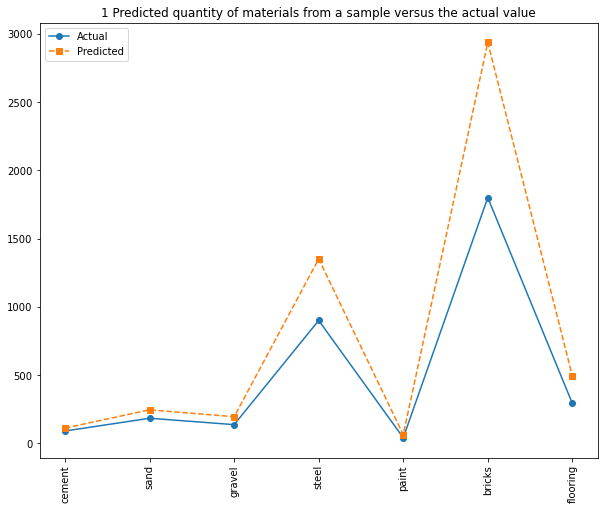

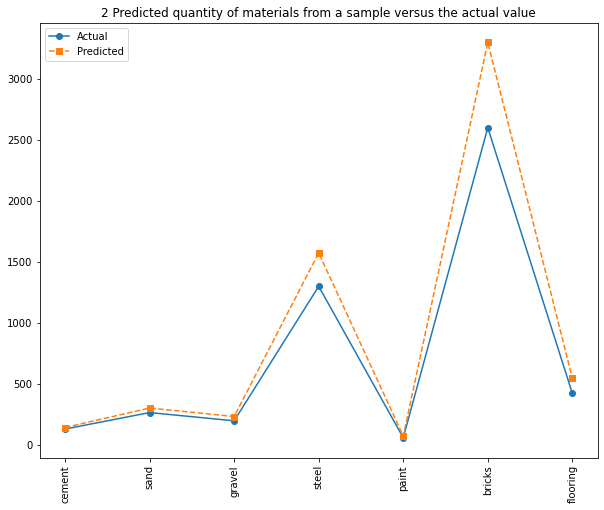

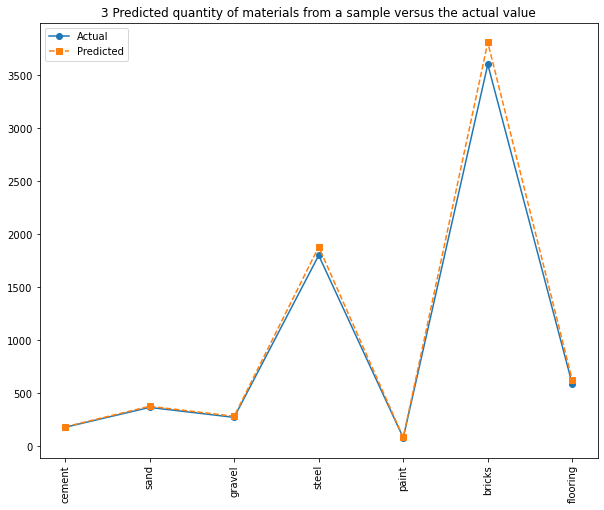

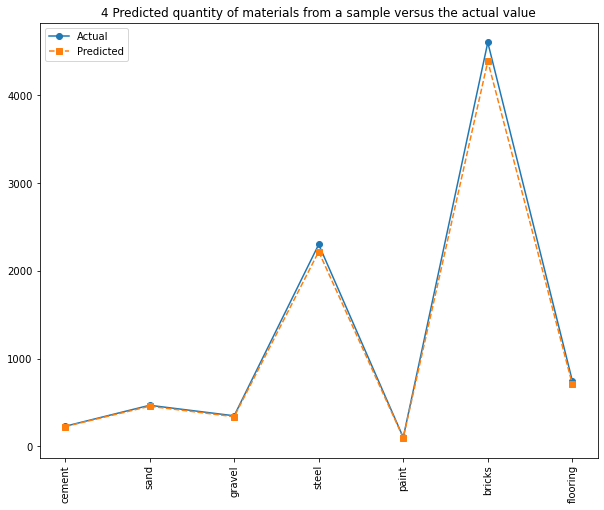

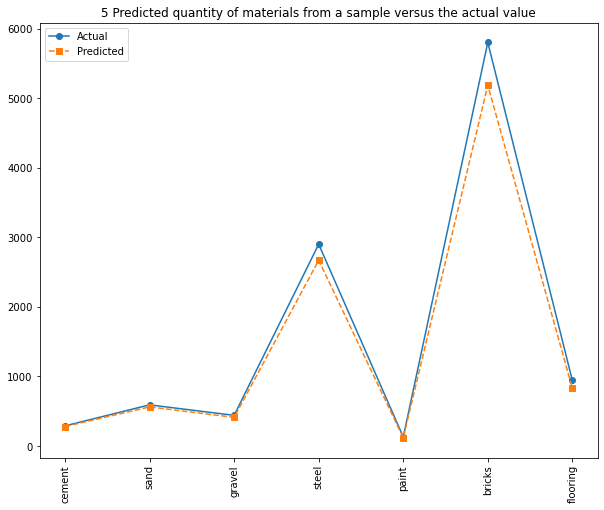

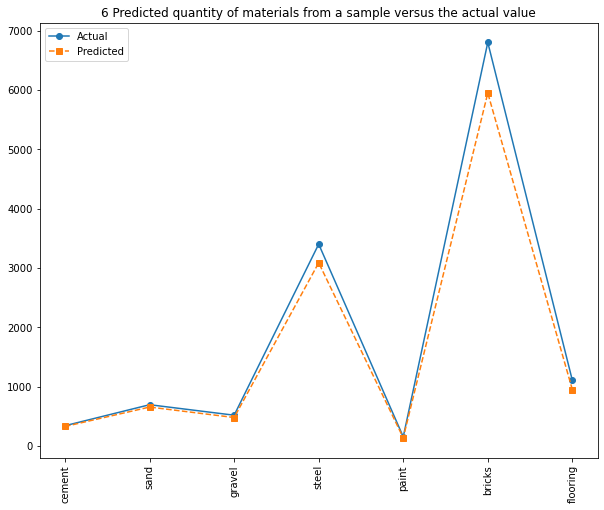

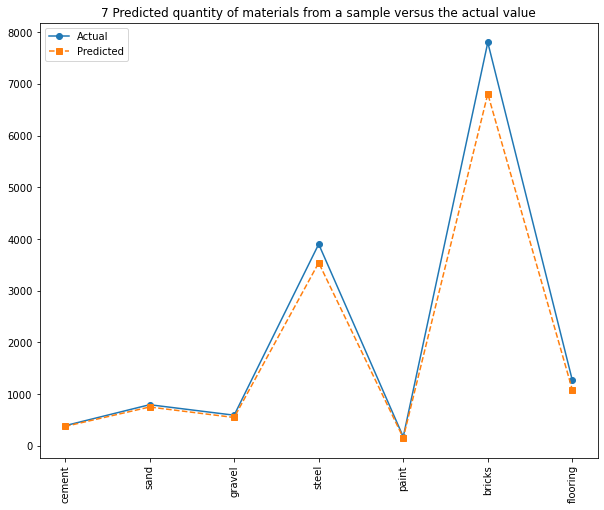

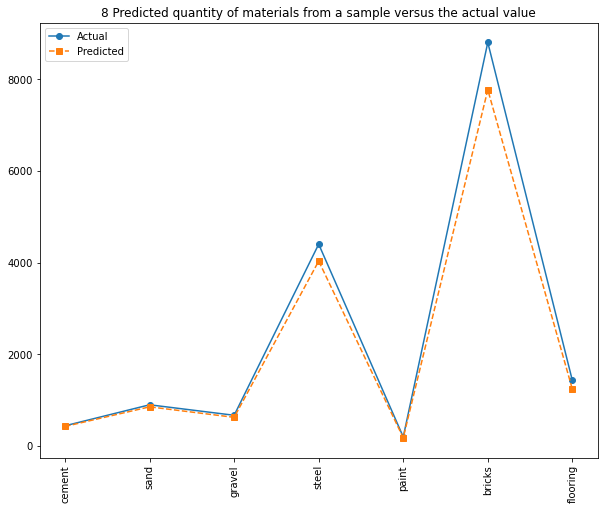

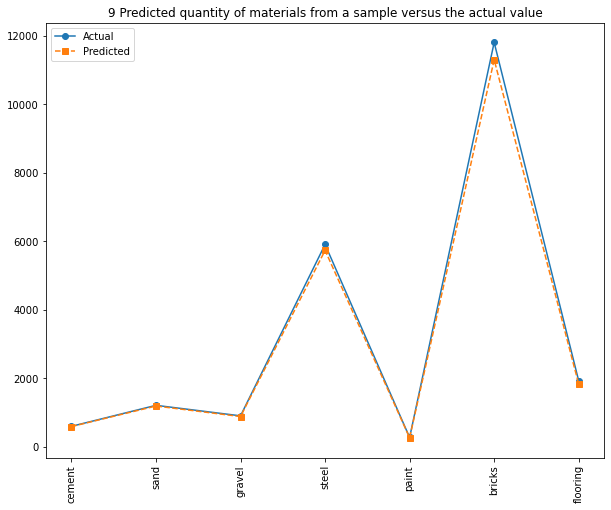

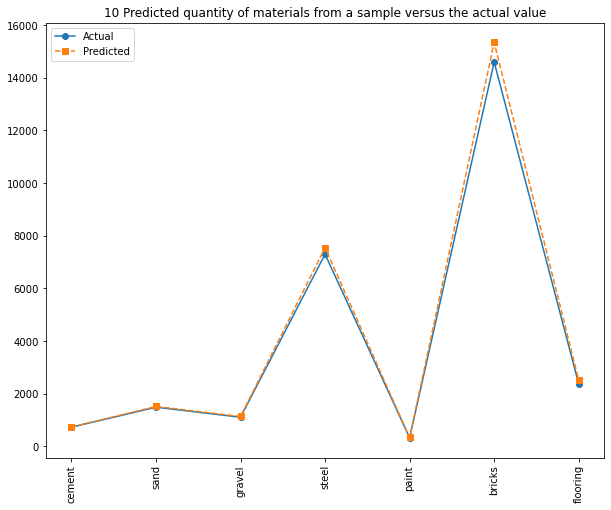

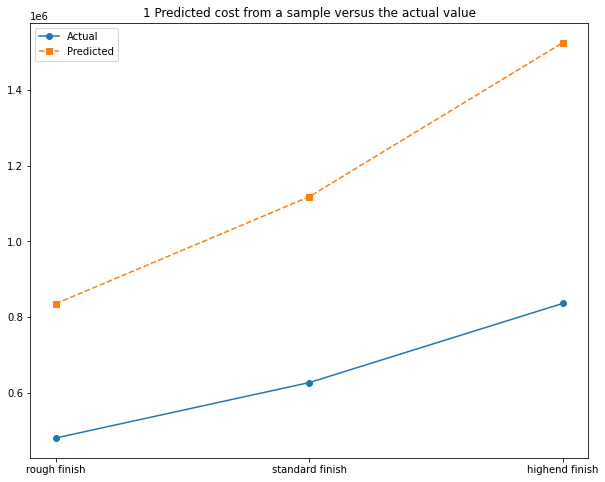

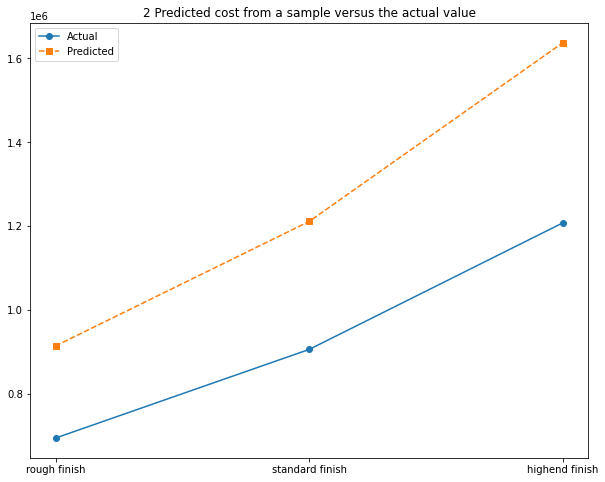

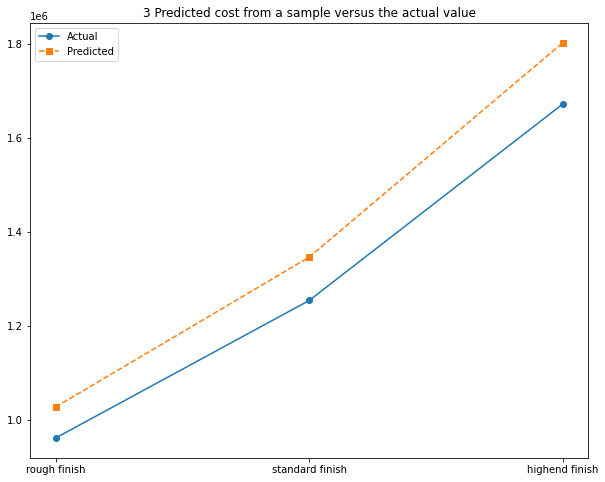

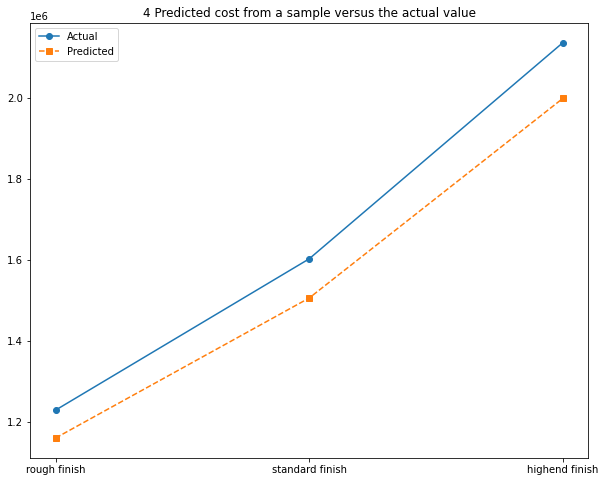

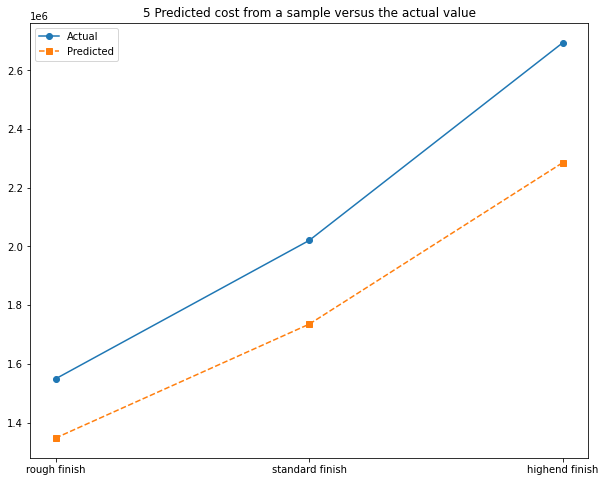

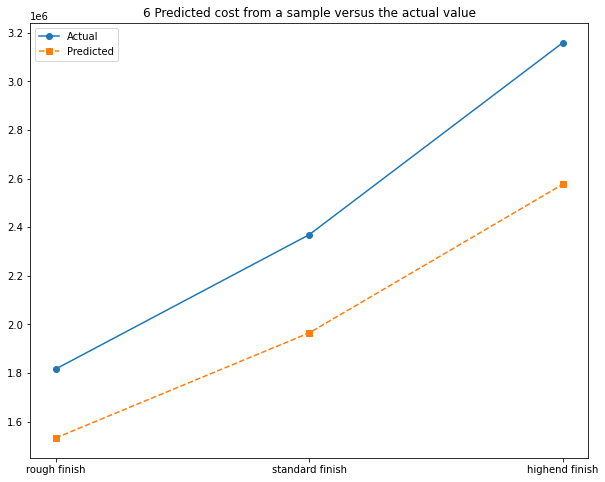

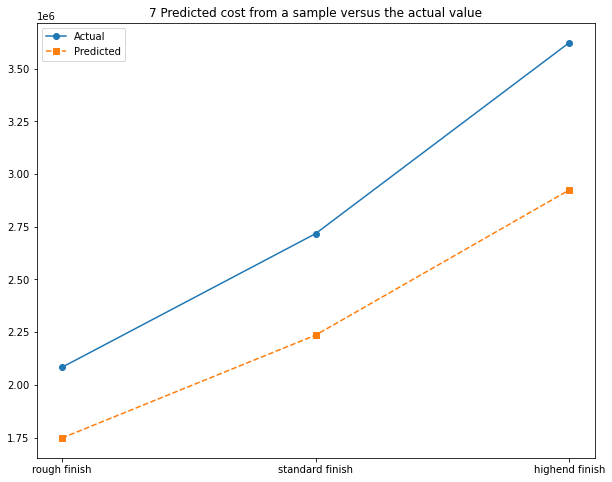

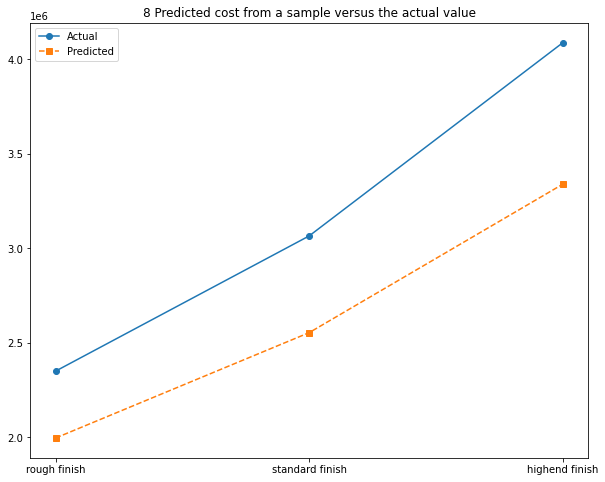

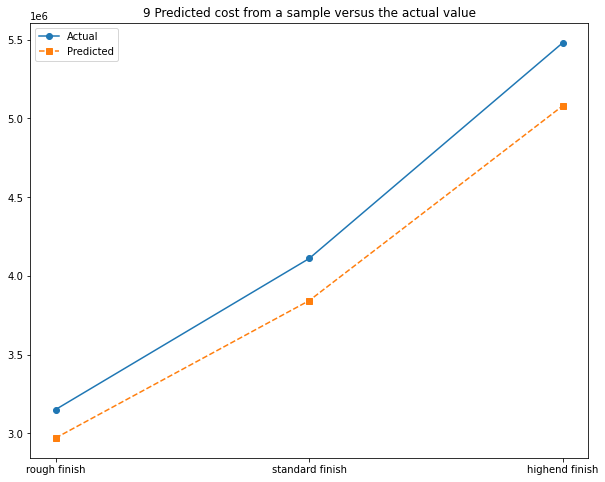

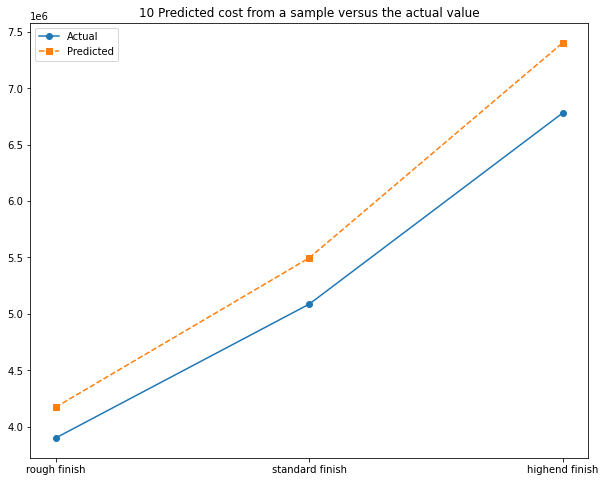

In [27]:
# model params

# define the LSTM model with a specified number of hidden units
model = LSTM(n_hidden=54)

# define the mean squared error loss function
criterion = nn.MSELoss()

# define the Adam optimizer with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# set the number of epochs for the training loop
n_steps = 1000

# training loop
def run_train():
    print('training...')
    for i in range(n_steps):
        # zero the gradient
        optimizer.zero_grad()

        # make a forward pass to get the output of the model
        out = model(train_x)

        # compute the mean squared error loss between the output and the target
        loss = criterion(out, train_y)

        # compute the gradients of the loss w.r.t to the parameters
        loss.backward()

        # iterate over all parameters(weights, bias) then update using the Adam optimizer
        optimizer.step()

        if i == n_steps - 1:
            print(f"step {i} / {n_steps} | Loss in training: {loss.item()}")
        

        # test the model by making future predictions on the test dataset
        with torch.no_grad():
            future = 10
            pred = model(test_x, future)
            loss = criterion(pred, test_y)
            y = pred.detach().numpy()

            # print the loss in the last iteration of testing
            if i == n_steps - 1:
                print(f"step {i} / {n_steps} | Loss in testing : {loss.item()}")

    
    # scale up values to their original scale for comparison
    y_s = sc.inverse_transform(test_y)
    pred_s = sc.inverse_transform(y)
    
    # plot the values
    y_act = y_s[:, 1:]
    y_pred = pred_s[:, 1:]
    
    quantity_labels = ['cement', 'sand', 'gravel', 'steel', 'paint', 'bricks', 'flooring']
    cost_labels = ['rough finish', 'standard finish', 'highend finish']

    
    # plot quantity predictions
    for i in range(len(y_act)):
        x_ticks = range(len(quantity_labels))
        
        plt.rcParams["figure.figsize"] = (10,8)
        plt.title(f"{i+1} Predicted quantity of materials from a sample versus the actual value")
        plt.plot(x_ticks, y_act[i][:7], 'o-', label='Actual')
        plt.plot(x_ticks, y_pred[i][:7], 's--', label='Predicted')
        plt.xticks(x_ticks, quantity_labels, rotation='vertical')
        plt.legend(loc="upper left")
        plt.show()
        
    # plot cost predictions
    for i in range(len(y_act)):
        x_ticks = range(len(cost_labels))
        
        plt.rcParams["figure.figsize"] = (10,8)
        plt.title(f"{i+1} Predicted cost from a sample versus the actual value")
        plt.plot(x_ticks, y_act[i][7:], 'o-', label='Actual')
        plt.plot(x_ticks, y_pred[i][7:], 's--', label='Predicted')
        plt.xticks(x_ticks, cost_labels)
        plt.legend(loc="upper left")
        plt.show()

    
run_train()

In [52]:
# save the model
PATH = 'main_model.pt'
torch.save(model.state_dict(), PATH)

In [54]:
# load and export the model to onnx
input_names = ["actual_input"]
output_names = ["output"]

trained_model = LSTM(n_hidden=52)
trained_model.load_state_dict(torch.load('main_model.pt'))
trained_model.eval()
dummy_input = torch.tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
torch.onnx.export(trained_model, 
                  dummy_input, 
                  'main_model.onnx', 
                  verbose=True,
                 input_names=input_names,
                 output_names=output_names,
                 export_params=True)